In [ ]:
import torchvision
import torch.utils.data as utils
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import time
import copy
from torch.optim import lr_scheduler
import os
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [ ]:
# First, look at everything.
from subprocess import check_output
print(check_output(["ls", "/content/drive/MyDrive/SignatureDetection/sign_data"]).decode("utf8"))

CNN_model.h5
CNN_model.json
sign_data
test
test_data.csv
train
train_data.csv



In [ ]:
class Config():
    training_dir = "/content/drive/MyDrive/SignatureDetection/sign_data/sign_data/train"
    testing_dir = "/content/drive/MyDrive/SignatureDetection/sign_data/sign_data/test"
    train_batch_size = 32
    train_number_epochs = 5

In [ ]:
training_dir="/content/drive/MyDrive/SignatureDetection/sign_data/train"
training_csv="/content/drive/MyDrive/SignatureDetection/sign_data/train_data.csv"
testing_csv="/content/drive/MyDrive/SignatureDetection/sign_data/test_data.csv"
testing_dir="/content/drive/MyDrive/SignatureDetection/sign_data/test"

In [ ]:
class SiameseNetworkDataset():

    def __init__(self,training_csv=None,training_dir=None,transform=None):
        # used to prepare the labels and images path
        self.training_df=pd.read_csv(training_csv)
        self.training_df.columns =["image1","image2","label"]
        self.training_dir = training_dir
        self.transform = transform

    def __getitem__(self,index):

        # getting the image path
        image1_path=os.path.join(self.training_dir,self.training_df.iat[index,0])
        image2_path=os.path.join(self.training_dir,self.training_df.iat[index,1])


        # Loading the image
        img0 = Image.open(image1_path)
        img1 = Image.open(image2_path)
        img0 = img0.convert("L")
        img1 = img1.convert("L")

        # Apply image transformations
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1 , torch.from_numpy(np.array([int(self.training_df.iat[index,2])],dtype=np.float32))

    def __len__(self):
        return len(self.training_df)

In [ ]:
# Load the the dataset from raw image folders
siamese_dataset = SiameseNetworkDataset(training_csv,training_dir,
                                        transform=transforms.Compose([transforms.Resize((105,105)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       )

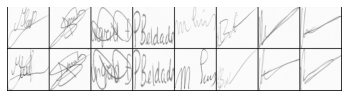

[[1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]]


In [ ]:
# Viewing the sample of images and to check whether its loading properly
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(

            nn.Conv2d(1, 96, kernel_size=11,stride=1),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5,stride=1,padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),

            nn.Conv2d(256,384 , kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384,256 , kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),

        )

        # Defining the fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(30976, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),

            nn.Linear(1024, 128),
            nn.ReLU(inplace=True),

            nn.Linear(128,2))



    def forward_once(self, x):
        # Forward pass
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward_once(input1)
        # forward pass of input 2
        output2 = self.forward_once(input2)
        return output1, output2

In [ ]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [ ]:
# Load the dataset as pytorch tensors using dataloader
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
# Check whether you have GPU is loaded or not
if torch.cuda.is_available():
    print('Yes')

Yes


In [ ]:
# Declare Siamese Network
net = SiameseNetwork().cuda()
# Decalre Loss Function
criterion = ContrastiveLoss()
# Declare Optimizer
optimizer = optim.RMSprop(net.parameters(), lr=1e-4, alpha=0.99, eps=1e-8, weight_decay=0.0005, momentum=0.9)

In [ ]:
def train():
    counter = []
    loss_history = []
    iteration_number= 0

    for epoch in range(0,Config.train_number_epochs):
        for i, data in enumerate(train_dataloader,0):
            img0, img1 , label = data
            img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
            optimizer.zero_grad()
            output1,output2 = net(img0,img1)
            loss_contrastive = criterion(output1,output2,label)
            loss_contrastive.backward()
            optimizer.step()
            if i %50 == 0 :
                print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
                iteration_number +=10
                counter.append(iteration_number)
                loss_history.append(loss_contrastive.item())
    return net

In [ ]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# # Train the model
# model = train()
# torch.save(model.state_dict(), "/content/drive/MyDrive/SignatureDetection/model.pt")
# print("Model Saved Successfully")

In [ ]:
# Load the saved model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SiameseNetwork().to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/SignatureDetection/model.pt"))

<All keys matched successfully>

In [ ]:
# Load the test dataset
test_dataset = SiameseNetworkDataset(training_csv=testing_csv,training_dir=testing_dir,
                                        transform=transforms.Compose([transforms.Resize((105,105)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       )

test_dataloader = DataLoader(test_dataset,num_workers=6,batch_size=1,shuffle=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


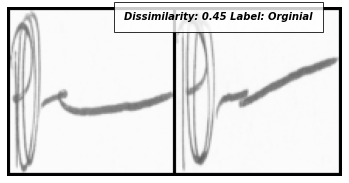

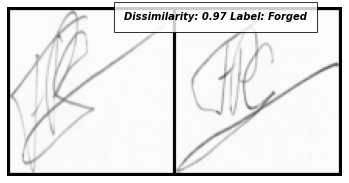

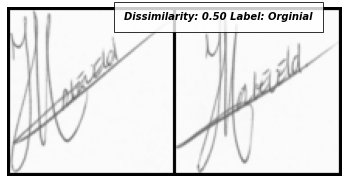

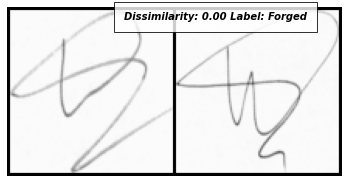

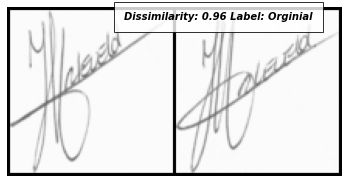

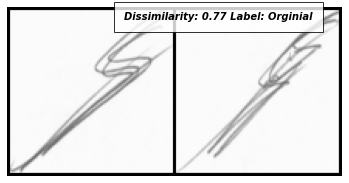

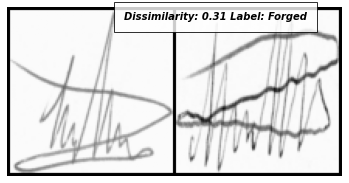

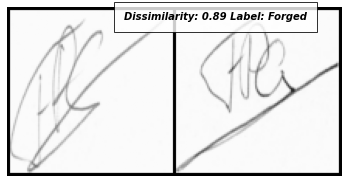

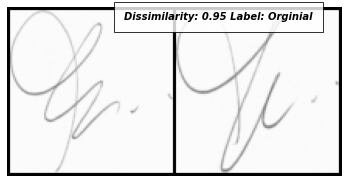

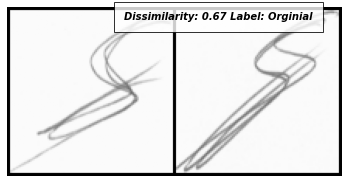

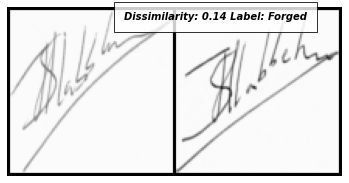

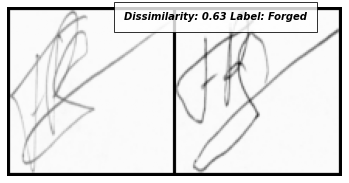

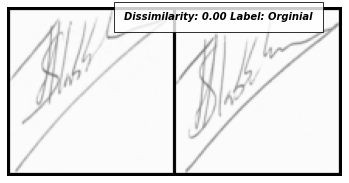

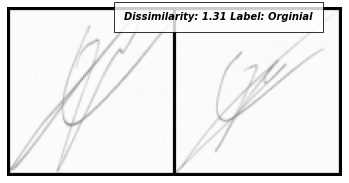

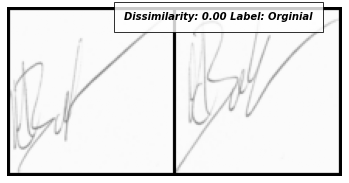

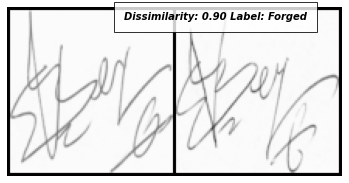

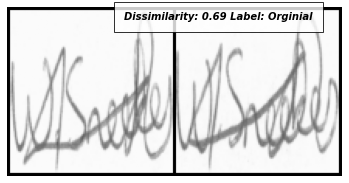

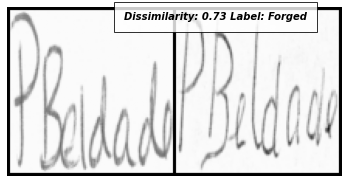

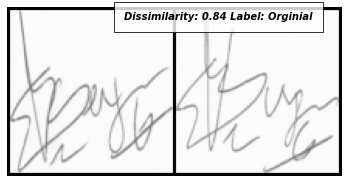

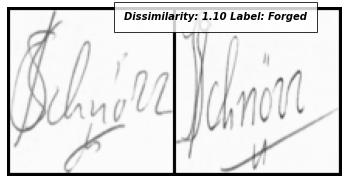

In [ ]:
# Print the sample outputs to view its dissimilarity
counter=0
list_0 = torch.FloatTensor([[0]])
list_1 = torch.FloatTensor([[1]])
for i, data in enumerate(test_dataloader,0):
  x0, x1 , label = data
  concatenated = torch.cat((x0,x1),0)
  output1,output2 = model(x0.to(device),x1.to(device))
  eucledian_distance = F.pairwise_distance(output1, output2)
  if label==list_0:
    label="Orginial"
  else:
    label="Forged"
  imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f} Label: {}'.format(eucledian_distance.item(),label))
  counter=counter+1
  if counter ==20:
     break

### Accuracy Check

In [ ]:
test_dataloader = DataLoader(test_dataset,num_workers=6,batch_size=1,shuffle=True)
accuracy=0
counter=0
correct=0
for i, data in enumerate(test_dataloader,0):
  x0, x1 , label = data
  # onehsot applies in the output of 128 dense vectors which is then converted to 2 dense vectors
  output1,output2 = model(x0.to(device),x1.to(device))
  res=torch.abs(output1.cuda() - output2.cuda())
  label=label[0].tolist()
  label=int(label[0])
  result=torch.max(res,1)[1].data[0].tolist()
  if label == result:
    correct=correct+1
  counter=counter+1
#   if counter ==20:
#      break

accuracy=(correct/len(test_dataloader))*100
print("Accuracy:{}%".format(accuracy))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1320: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Accuracy:48.68627109796416%


# CNN

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
train_dir="/content/drive/MyDrive/SignatureDetection/sign_data/sign_data/train/"
test_dir="/content/drive/MyDrive/SignatureDetection/sign_data/sign_data/test/"

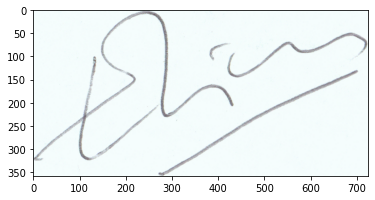

In [ ]:
import matplotlib.pyplot as plt
img = plt.imread('/content/drive/MyDrive/SignatureDetection/sign_data/sign_data/train/001/001_01.PNG')
plt.imshow(img)

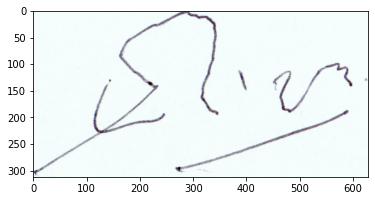

In [ ]:
img1 = plt.imread('/content/drive/MyDrive/SignatureDetection/sign_data/sign_data/train/001_forg/0119001_01.png')
plt.imshow(img1)

In [ ]:
SIZE = 224

In [ ]:
import cv2
import os
import glob

train_data = []
train_labels = []

for per in os.listdir('/content/drive/MyDrive/SignatureDetection/sign_data/sign_data/train/'):
    for data in glob.glob('/content/drive/MyDrive/SignatureDetection/sign_data/sign_data/train/'+per+'/*.*'):
        img = cv2.imread(data)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (SIZE,SIZE))
        train_data.append([img])
        if per[-1]=='g':
            train_labels.append(np.array(1))
        else:
            train_labels.append(np.array(0))

train_data = np.array(train_data)/255.0
train_labels = np.array(train_labels)

#Test Data

test_data = []
test_labels = []

for per in os.listdir('/content/drive/MyDrive/SignatureDetection/sign_data/sign_data/test/'):
    for data in glob.glob('/content/drive/MyDrive/SignatureDetection/sign_data/sign_data/test/'+per+'/*.*'):
        img = cv2.imread(data)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (SIZE,SIZE))
        test_data.append([img])
        if per[-1]=='g':
            test_labels.append(np.array(1))
        else:
            test_labels.append(np.array(0))

test_data = np.array(test_data)/255.0
test_labels = np.array(test_labels)

In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.8.0


In [ ]:
from tensorflow.keras.utils import to_categorical
train_labels = to_categorical(train_labels)

In [ ]:
train_data.shape

(1649, 1, 224, 224, 3)

In [ ]:
train_data = train_data.reshape(-1, SIZE,SIZE, 3)
test_data = test_data.reshape(-1, SIZE,SIZE, 3)

In [ ]:
train_data.shape

(1649, 224, 224, 3)

In [ ]:
train_labels.shape

(1649, 2)

In [ ]:
from sklearn.utils import shuffle
train_data,train_labels = shuffle(train_data,train_labels)
test_data,test_labels = shuffle(test_data,test_labels)

In [ ]:
import tensorflow as tf


In [ ]:
from keras.models import Sequential, Model, load_model
from tensorflow.keras import applications
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam

base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.summary()

add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(256, activation='relu'))
add_model.add(Dense(2, activation='softmax'))

model_CNN = Model(inputs=base_model.input, outputs=add_model(base_model.output))
model_CNN.compile(loss='categorical_crossentropy', optimizer=tf.optimizers.Adam(lr=1e-4),
              metrics=['accuracy'])

model_CNN.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
# earlyStopping = EarlyStopping(monitor='val_loss',
#                               min_delta=0,
#                               patience=3,
#                               verbose=1)

# early_stop=[earlyStopping]


# EPOCHS = 9
# BS = 64
# progess = model_CNN.fit(train_data,train_labels, batch_size=BS,epochs=EPOCHS, callbacks=early_stop,validation_split=.3)

In [ ]:
# acc = progess.history['accuracy']
# val_acc = progess.history['val_accuracy']
# loss = progess.history['loss']
# val_loss = progess.history['val_loss']

# epochs = range(len(acc))

# plt.plot(epochs, acc, 'b', label='Training acc')
# plt.plot(epochs, val_acc, 'r', label='Validation acc')
# plt.title('Training and validation accuracy')
# plt.legend()

# plt.figure()

In [ ]:
# plt.plot(epochs, loss, 'b', label='Training loss')
# plt.plot(epochs, val_loss, 'r', label='Validation loss')
# plt.title('Training and validation loss')
# plt.legend()

# plt.show()

In [ ]:
from keras.models import model_from_json
# serialize model to JSON
model_json = model_CNN.to_json()
with open("/content/drive/MyDrive/SignatureDetection/sign_data/CNN_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_CNN.save_weights("/content/drive/MyDrive/SignatureDetection/sign_data/CNN_model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:


# later...

# load json and create model
json_file = open('/content/drive/MyDrive/SignatureDetection/sign_data/CNN_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/drive/MyDrive/SignatureDetection/sign_data/CNN_model.h5")
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
pred = loaded_model.predict(test_data)

from sklearn.metrics import accuracy_score
accuracy_score(np.argmax(pred,axis=1), test_labels)

Loaded model from disk


In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(np.argmax(pred,axis=1), test_labels)